In [9]:
%load_ext autoreload
%autoreload 2
import itertools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import experiments
import utils
from granularity import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# AFFECT (SNOW)

In [2]:
DATA_DIR = "data/snow_affect/"
EMOTIONS = ["surprise", "disgust", "sadness", "fear", "valence", "joy", "anger"]
def load_snow(relfilepath):
    return pd.read_csv(relfilepath, sep="\t").set_index("!amt_annotation_ids")
dfs = [load_snow(DATA_DIR + f + ".standardized.tsv") for f in EMOTIONS]
full_df = pd.concat(dfs, join="inner", axis=1)

full_df["annotation"] = full_df["response"].values.tolist()
full_df["groundtruth"] = full_df["gold"].values.tolist()
full_df["uid"] = full_df["!amt_worker_ids"].values[:,0]
full_df["item"] = full_df["orig_id"].values[:,0]

full_df = full_df[["item", "uid", "annotation", "groundtruth"]]
full_df

,item,uid,annotation,groundtruth
!amt_annotation_ids,,,,
6YGZG117Y18TYYYVYYZZKSA0RSZD235RTEMFMA3Z,594,A1AVJRFM6L0RN8,"[0, 50, 25, 25, 0, 25, 25]","[6, 2, 11, 56, -66, 0, 37]"
6YGZG117Y18TYYYVYYZZGWPTRNMNZYM8NJ4AQG1Z,594,ADAGUJNWMEPT6,"[5, 50, 25, 60, -60, 0, 80]","[6, 2, 11, 56, -66, 0, 37]"
6YGZG117Y18TYYYVYYZZKJ2ZTRYE1W0ZVJWF0TC0,594,A1LY3NJTYW9TFF,"[0, 0, 0, 0, 0, 0, 5]","[6, 2, 11, 56, -66, 0, 37]"
6YGZG117Y18TYYYVYYZZQZ8Y2ZZKMJH8KJY6G020,594,A14WWG6NKBDWGP,"[40, 30, 20, 30, -50, 0, 30]","[6, 2, 11, 56, -66, 0, 37]"
6YGZG117Y18TYYYVYYZZJW5ZW9R40YCCJ80X2YF0,594,A1VYRD3HO2WDUN,"[0, 50, 50, 50, -50, 0, 20]","[6, 2, 11, 56, -66, 0, 37]"
...,...,...,...,...
6YGZG117Y18TYYYVYYZZQG0Z4ZZVQY58M2YQR2VZ,595,A1XUURRBT9RYFW,"[5, 5, 5, 50, -20, 0, 5]","[22, 15, 22, 75, -45, 17, 27]"
6YGZG117Y18TYYYVYYZZ4W0Z4NY88RHRV3ZZVSK0,595,A1M0SEWUJYX9K0,"[0, 60, 90, 60, -95, 0, 40]","[22, 15, 22, 75, -45, 17, 27]"
6YGZG117Y18TYYYVYYZZSXXT57ZJXHVMMQY23VWZ,595,A2KBTYNGUFRB9N,"[10, 30, 0, 60, -40, 0, 30]","[22, 15, 22, 75, -45, 17, 27]"


#### Given a dataset formated as above, we can setup an experiment as follows. Note the definitions of evaluation (eval) and distance functions that operate on annotations and ground truth.

In [3]:
def rmse(x, y):
    return np.sqrt(np.mean(np.square(np.array(x) / 100 - np.array(y) / 100)))
eval_fn = lambda x,y: 1 / rmse(x,y) 
affect_experiment = experiments.RealExperiment(eval_fn, "annotation", "item", "uid", distance_fn=rmse)
affect_experiment.setup(full_df, full_df[["item", "groundtruth"]], c_gold_label="groundtruth")
affect_experiment.annodf

100%|██████████| 100/100 [00:04<00:00, 22.62it/s]


,uid,item,annotation
!amt_annotation_ids,,,
6YGZG117Y18TYYYVYYZZKSA0RSZD235RTEMFMA3Z,6,94,"[0, 50, 25, 25, 0, 25, 25]"
6YGZG117Y18TYYYVYYZZGWPTRNMNZYM8NJ4AQG1Z,30,94,"[5, 50, 25, 60, -60, 0, 80]"
6YGZG117Y18TYYYVYYZZKJ2ZTRYE1W0ZVJWF0TC0,8,94,"[0, 0, 0, 0, 0, 0, 5]"
6YGZG117Y18TYYYVYYZZQZ8Y2ZZKMJH8KJY6G020,0,94,"[40, 30, 20, 30, -50, 0, 30]"
6YGZG117Y18TYYYVYYZZJW5ZW9R40YCCJ80X2YF0,12,94,"[0, 50, 50, 50, -50, 0, 20]"
...,...,...,...
6YGZG117Y18TYYYVYYZZQG0Z4ZZVQY58M2YQR2VZ,14,95,"[5, 5, 5, 50, -20, 0, 5]"
6YGZG117Y18TYYYVYYZZ4W0Z4NY88RHRV3ZZVSK0,9,95,"[0, 60, 90, 60, -95, 0, 40]"
6YGZG117Y18TYYYVYYZZSXXT57ZJXHVMMQY23VWZ,17,95,"[10, 30, 0, 60, -40, 0, 30]"


In [4]:
affect_experiment.describe_data()

38 & 100 & 1000 & 26.32$\pm$31.92 & 10.0$\pm$0.0 & 60


#### The following code trains and tests the data. For each method, we see the name, the random-user (baseline) score followed by the model's score. This score reflects the eval function on the model's selected annotation for that item against the known gold.

Pickled model loaded
BEST AVAILABLE USER
5.428651477487052 6.373724808798359
t-test Ttest_relResult(statistic=-4.84470437121756, pvalue=1.695016376340943e-06)
z-score 0.21687875340000862
baseline below thresh 0.0
model below thresh 0.0
BEST HONEYPOT USER
5.428651477487052 5.513705239569975
t-test Ttest_relResult(statistic=-0.4699930586687649, pvalue=0.6385653061407387)
z-score 0.021039778872022616
baseline below thresh 0.0
model below thresh 0.0
SMALLEST AVERAGE DISTANCE
5.428651477487052 6.551911855129005
t-test Ttest_relResult(statistic=-6.5367509951053835, pvalue=1.5561110261360898e-10)
z-score 0.29262516316314113
baseline below thresh 0.0
model below thresh 0.0
HEURISTIC
5.428651477487052 6.524647644615006
t-test Ttest_relResult(statistic=-6.350830783285221, pvalue=4.823829711738277e-10)
z-score 0.2843022314253499
baseline below thresh 0.0
model below thresh 0.0
MULTIDIMENSIONAL ANNOTATION SCALING
5.428651477487052 6.736297247697383
t-test Ttest_relResult(statistic=-5.6402221983617

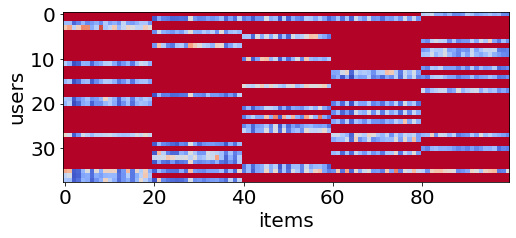

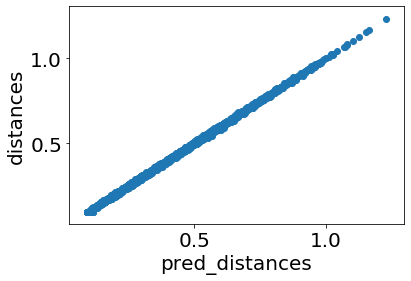

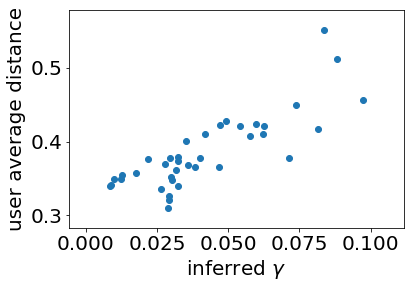

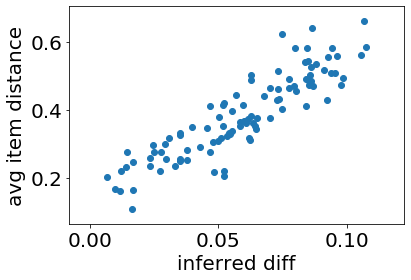

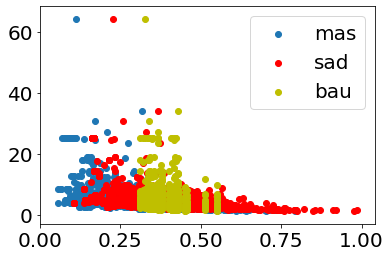


 ALL
ru 0 4.532295431181768
bau -0.15752821700583364 4.525059037864473
sad -0.4251814624994614 4.468371611234149
mas -0.4229437402072877 4.478736072361283


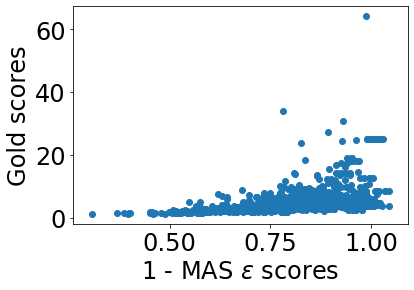

Proper scores
MAS 0.7300130865122624
SAD 0.7300885994003313
BAU 0.7298967180045683


In [7]:
affect_experiment.train(iter=1000)
affect_experiment.test(debug=True)
_ = affect_experiment.debug(plot_vs_gold=True, skip_miniplots=True)

#### Collect each model's predicted best annotations (e.g. bau_preds, sad_preds, etc) as follows:

In [8]:
# itemID: model's predicted best annotation
affect_experiment.mas_preds

{0: [15, 0, 0, 0, 0, 12, 0],
 1: [0, 40, 30, 0, -40, 0, 40],
 2: [0, 0, 0, 0, 0, 0, 0],
 3: [0, 0, 0, 0, 0, 0, 0],
 4: [0, 0, 15, 56, -10, 0, 0],
 5: [30, 15, 40, 15, -30, 0, 20],
 6: [0, 0, 0, 0, 0, 0, 0],
 7: [0, 0, 10, 0, 0, 0, 0],
 8: [30, 20, 30, 5, -30, 0, 15],
 9: [20, 40, 69, 12, -35, 0, 54],
 10: [0, 40, 50, 20, -50, 0, 50],
 11: [10, 0, 0, 0, 0, 0, 0],
 12: [0, 0, 0, 0, 0, 0, 0],
 13: [15, 0, 0, 0, 0, 0, 0],
 14: [10, 20, 20, 10, -10, 0, 10],
 15: [5, 0, 0, 0, 0, 0, 0],
 16: [0, 25, 31, 0, 45, 0, 20],
 17: [20, 0, 23, 20, 0, 0, 0],
 18: [0, 0, 30, 30, 0, 0, 10],
 19: [20, 5, 0, 0, 0, 0, 0],
 20: [0, 0, 0, 0, 0, 0, 0],
 21: [0, 0, 0, 0, 40, 35, 0],
 22: [0, 10, 0, 0, -20, 0, 0],
 23: [0, 10, 0, 0, -10, 0, 10],
 24: [0, 0, 0, 0, 0, 0, 0],
 25: [10, 0, 0, 0, 0, 0, 0],
 26: [20, 0, 0, 0, 20, 20, 0],
 27: [25, 0, 0, 0, 0, 0, 0],
 28: [23, 98, 45, 16, 0, 65, 46],
 29: [20, 0, 0, 0, 0, 0, 0],
 30: [5, 0, 0, 0, 10, 20, 0],
 31: [0, 0, 0, 0, 0, 0, 0],
 32: [0, 0, 0, 0, 0, 0, 0],
 33: 

## GRANULARITY

[([3, 3], [7, 7]), ([6, 6], [9, 9]), ([5, 8], [8, 9])]
[([3, 3], [9, 9])]


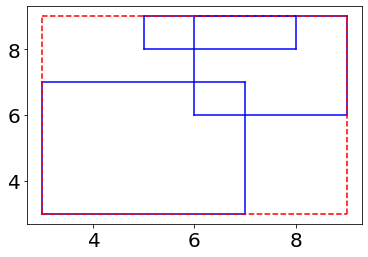

In [25]:
def plot_vectorrange(vr, color="b"):
    plt.plot([vr.start_vector[0], vr.end_vector[0]], [vr.start_vector[1], vr.start_vector[1]], color)
    plt.plot([vr.start_vector[0], vr.start_vector[0]], [vr.start_vector[1], vr.end_vector[1]], color)
    plt.plot([vr.start_vector[0], vr.end_vector[0]], [vr.end_vector[1], vr.end_vector[1]], color)
    plt.plot([vr.end_vector[0], vr.end_vector[0]], [vr.start_vector[1], vr.end_vector[1]], color)


# each "VectorRange" defines top-left and bottom-right coordinates of bounding box
example_vectorranges = [VectorRange([3,3], [7,7]), VectorRange([6,6], [9,9]), VectorRange([5,8], [8,9])]
print(example_vectorranges)

for vr in example_vectorranges:
    plot_vectorrange(vr)
    
unionized_vectorranges = unionize_vectorrange_sequence(example_vectorranges)
print(unionized_vectorranges)

plot_vectorrange(unionized_vectorranges[0], "r--")

plt.show()

In [27]:
print(set([SeqRange([11,22]), SeqRange([27,34])]))
print(set([SeqRange([11,27]), SeqRange([22,34])]))
print(set([SeqRange([11,27]), SeqRange([22,25])]))
print(set([SeqRange([0,60]), SeqRange([60,111])]))
seqranges = [(60, 112), (510, 518), (313, 321), (617, 625), (0, 60), (60, 769), (19, 25), (510, 518), (66, 73), (60, 112), (309, 321), (507, 518), (752, 767), (60, 112), (507, 552), (309, 321), (12, 25), (60, 112), (697, 716), (60, 112), (309, 380), (60, 112), (309, 380)]
print(unionize_range_sequence(seqranges))

{([11], [22]), ([27], [34])}
{([11], [34])}
{([11], [27])}
{([0], [111])}
[([0], [769])]


# PICO

In [28]:
rawdf = pd.read_json("data/PICO/PICO-annos-crowdsourcing.json", lines=True)
aggdf = pd.read_json("data/PICO/PICO-annos-crowdsourcing-agg.json", lines=True)
golddf = pd.read_json("data/PICO/PICO-annos-professional.json", lines=True)

In [29]:
userIDs = []
itemIDs = []
labels = []
golds = []
hmmcrowds = []
dawidskenes = []
majorityvotes = []
for row in rawdf.iterrows():
    itemID = row[1]["docid"]
    data = row[1]["Participants"]
    gold = golddf[golddf["docid"] == itemID]["Participants"].values[0]
    gold = gold.get("MedicalStudent")
    agg = aggdf[aggdf["docid"] == itemID]["Participants"].values[0]
    for userID, label in data.items():
        userIDs.append(userID)
        itemIDs.append(itemID)
        labels.append(label)
        golds.append(gold)
        hmmcrowds.append(agg["HMMCrowd"])
        dawidskenes.append(agg["DawidSkene"])
        majorityvotes.append(agg["MajorityVote"])
df = pd.DataFrame({"uid":userIDs, "itemID":itemIDs, "label":labels, "gold":golds,
                  "HMMCrowd":hmmcrowds, "DawidSkene":dawidskenes, "MajorityVote":majorityvotes})
df = df.sort_values("itemID")
userIdDict = utils.make_categorical(df, "uid")
itemIdDict = utils.make_categorical(df, "itemID")

In [30]:
orig_golddict = df.set_index("itemID").to_dict()["gold"]
orig_golddict = {k: v for k, v in orig_golddict.items() if v is not None}

In [31]:
def labels2set(labels):
    ranges = [range(s[0], s[1]+1) for s in labels]
    return set(itertools.chain.from_iterable(ranges))

def list2ranges(i):
    result = []
    for a, b in itertools.groupby(enumerate(i), lambda k: k[1] - k[0]):
        b = list(b)
        result.append([b[0][1], b[-1][1]])
    return result

def intersects_per_span(a_spans, b_spans):
    a_sets = [labels2set([a]) for a in a_spans]
    b_set = labels2set(b_spans)
    scores = [len(a.intersection(b_set)) / len(a) for a in a_sets]
    return np.mean(scores)

def eval_precision(pred_spans, gold_spans):
    return intersects_per_span(pred_spans, gold_spans)

def eval_recall(pred_spans, gold_spans):
    return intersects_per_span(gold_spans, pred_spans)

def eval_f1(a_spans, b_spans):
    p = eval_precision(a_spans, b_spans)
    r = eval_precision(b_spans, a_spans)
    denom = (p + r)
    return 2 * p * r / denom if denom > 0 else 0

In [33]:
dfs = []
for item_id in df["itemID"].unique():
    idf = df[df["itemID"] == item_id]
    gold = idf["gold"].values[0]
    if gold is None:
        continue
    seqranges = [SeqRange(x) for y in idf["label"].values for x in y] + [SeqRange(x) for x in gold]
    unranges = unionize_vectorrange_sequence(seqranges)
    origItemID = []
    newItemID = []
    uid = []
    label = []
    gold = []
    for unrange in unranges:
        for i, row in idf.iterrows():
            origItemID.append(idf['itemID'].values[0])
            newItemID.append(F"{idf['itemID'].values[0]}-{unrange}")
            uid.append(row["uid"])
            label.append([SeqRange(x) for x in row["label"] if unrange == SeqRange(x)])
            gold.append([SeqRange(x) for x in row["gold"] if unrange == SeqRange(x)])
    dfs.append(pd.DataFrame({"origItemID":origItemID, "newItemID":newItemID, "uid":uid, "label":label, "gold":gold}))
granular_df = pd.concat(dfs)


In [58]:
granular_df[granular_df["origItemID"]==0]

,origItemID,newItemID,uid,label,gold
0,0,"0-([5], [44])",34,[],"[([21], [44])]"
1,0,"0-([5], [44])",27,"[([21], [44])]","[([21], [44])]"
2,0,"0-([5], [44])",13,[],"[([21], [44])]"
3,0,"0-([5], [44])",79,"[([5], [44])]","[([21], [44])]"
4,0,"0-([5], [44])",7,"[([5], [17])]","[([21], [44])]"
5,0,"0-([5], [44])",89,[],"[([21], [44])]"
6,0,"0-([5], [44])",15,"[([21], [44])]","[([21], [44])]"
7,0,"0-([61], [147])",34,[],[]
8,0,"0-([61], [147])",27,"[([67], [76])]",[]
9,0,"0-([61], [147])",13,"[([67], [147])]",[]


In [59]:
gran_gold_df = granular_df.groupby("newItemID").first().reset_index()[["newItemID", "gold"]]

In [60]:
gran_exp = experiments.RealExperiment(eval_f1, "label", "newItemID", "uid")
gran_exp.setup(granular_df, gran_gold_df, c_gold_label="gold", merge_index="origItemID")
gran_exp.annodf

  0%|          | 0/1112 [00:00<?, ?it/s]/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1112/1112 [00:24<00:00, 46.21it/s]


,uid,newItemID,label,origItemID
0,34,4,[],0
1,27,4,"[([21], [44])]",0
2,13,4,[],0
3,79,4,"[([5], [44])]",0
4,7,4,"[([5], [17])]",0
...,...,...,...,...
37,9,588,[],190
38,62,588,[],190
39,13,588,[],190
40,34,588,[],190


#### Following code will train on the granular-item annotations and then merge back to test on the original items. Note there are some bugs displaying the correctly merged random-user and oracle scores.

In [61]:
gran_exp.train(iter=0) # iter=0 => don't train MAS

mv_labels = dict(df.groupby("itemID").first()["MajorityVote"].dropna())
hmm_labels = dict(df.groupby("itemID").first()["HMMCrowd"].dropna())
gran_exp.register_baseline("Tokenwise MV", mv_labels)
gran_exp.register_baseline("Crowd-HMM", hmm_labels)
gran_exp.test_merged(orig_golddict)

Pickled model loaded


/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


BEST AVAILABLE USER
0.02299426643828092 0.7008890251091879
t-test Ttest_relResult(statistic=-96.12686414134873, pvalue=0.0)
z-score 3.1369816539772932
baseline below thresh 0.0
model below thresh 0.0
BEST HONEYPOT USER
0.02299426643828092 0.0
t-test Ttest_relResult(statistic=9.388973222289085, pvalue=4.4436565826989007e-20)
z-score -0.30639756129666335
baseline below thresh 0.0
model below thresh 0.0
SMALLEST AVERAGE DISTANCE
0.02299426643828092 0.693303349766995
t-test Ttest_relResult(statistic=-89.15694668750993, pvalue=0.0)
z-score 2.9095269941615105
baseline below thresh 0.0
model below thresh 0.0
HEURISTIC
0.02299426643828092 0.7014589315734812
t-test Ttest_relResult(statistic=-92.59436661586892, pvalue=0.0)
z-score 3.0217029540099682
baseline below thresh 0.0
model below thresh 0.0
MULTIDIMENSIONAL ANNOTATION SCALING
0.02299426643828092 0.0
t-test Ttest_relResult(statistic=9.388973222289085, pvalue=4.4436565826989007e-20)
z-score -0.30639756129666335
baseline below thresh 0.0
mod

In [62]:
# SAD best annotation predictions for the original items
gran_exp.sad_preds

{0: [([5], [44]),
  ([61], [135]),
  ([271], [294]),
  ([362], [421]),
  ([568], [580]),
  ([1103], [1123])],
 1: [([60], [112]), ([309], [321]), ([507], [552])],
 2: [([52], [76]), ([198], [218])],
 3: [([191], [257]), ([259], [313]), ([1440], [1487])],
 4: [([196], [310]), ([454], [504]), ([948], [972])],
 5: [([57], [118]), ([372], [406]), ([1389], [1407])],
 6: [([93], [152]), ([341], [435])],
 7: [([85], [108]),
  ([111], [160]),
  ([347], [388]),
  ([419], [474]),
  ([1590], [1611])],
 8: [([29], [58]), ([129], [177])],
 9: [([107], [137]), ([139], [257]), ([1183], [1217])],
 10: [([65], [98]),
  ([102], [113]),
  ([313], [363]),
  ([929], [932]),
  ([1213], [1260])],
 11: [([48], [73]),
  ([231], [289]),
  ([290], [350]),
  ([702], [730]),
  ([1147], [1202])],
 12: [([67], [99]), ([201], [221])],
 13: [([67], [107]), ([409], [451]), ([605], [655])],
 14: [([349], [390])],
 15: [([228], [257]), ([347], [358])],
 16: [([26], [34]), ([233], [311]), ([357], [422]), ([854], [927])],
